In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

This is part 2 of the [Road to the Top](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) series, in which I show the process I used to tackle the [Paddy Doctor](https://www.kaggle.com/competitions/paddy-disease-classification) competition, leading to four 1st place submissions. If you haven't already, first check out [part 1](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1).

## Going faster

First we'll repeat the steps we used last time to access the data and ensure all the latest libraries are installed:

In [2]:
comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
from fastai.vision.all import *
set_seed(42)

A big issue I noticed last time was that originally I created the notebook on my home PC, and each epoch of the resnet we created took under 20 seconds to run. But on Kaggle they took over 3 minutes each! Whilst Kaggle's GPUs are less powerful than what I've got at home, that doesn't come close to explaining this vast difference in speed.

I noticed when Kaggle was running that the "GPU" indicator in the top right was nearly empty, and the "CPU" one was always full. This strongly suggests that the problem was that Kaggle's notebook was CPU bound by decoding and resizing the images. This is a common problem on machines with poor CPU performance -- and indeed Kaggle only provides 2 virtual CPUs at the time of writing.

We really need to fix this, since we need to be able to iterate much more quickly. What we can do is to simply resize all the images to half their height and width -- which reduces their number of pixels 4x. This should mean an around 4x increase in performance for training small models.

Luckily, fastai has a function which does exactly this, whilst maintaining the folder structure of the data: `resize_images`.

In [3]:
trn_path = Path('sml')

In [4]:
resize_images(path/'train_images', dest=trn_path, max_size=256, recurse=True)

This will give us 192x256px images. Let's take a look:

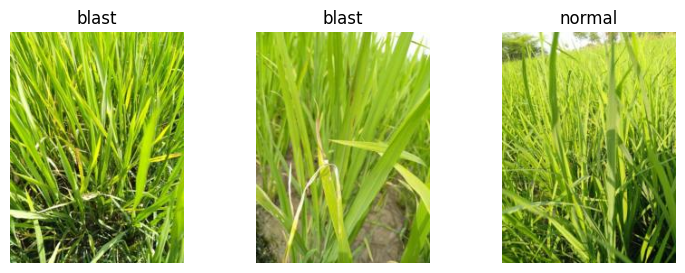

In [5]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize((256,192)))

dls.show_batch(max_n=3)

In this notebook, we'll be experimenting with a few different architectures and image processing approaches (item and batch transforms). In order to make this easier, we'll put our modeling steps together into a little function which we can pass the architecture, item transforms, and batch transforms to:

In [6]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

Our `item_tfms` already resize our images to small sizes, so this shouldn't impact the accuracy of our models much, if at all. Let's re-run our resnet26d to test.

In [7]:
learn = train('resnet26d', item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.926469,1.460401,0.442095,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.250763,1.004393,0.332532,00:05
1,0.974856,0.640816,0.204229,00:05
2,0.709769,0.479054,0.146564,00:05
3,0.518294,0.389160,0.111485,00:05
4,0.422685,0.361630,0.102835,00:05


That's a big improvement in speed, and the accuracy looks fine.

## A ConvNeXt model

I noticed that the GPU usage bar in Kaggle was still nearly empty, so we're still CPU bound. That means we should be able to use a more capable model with little if any speed impact. Let's look again at the options in [The best vision models for fine-tuning](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning). `convnext_small` tops the performance/accuracy tradeoff score there, so let's give it a go!

In [8]:
arch = 'convnext_small_in22k'

In [9]:
learn = train(arch, item=Resize(192, method='squish'),
              batch=aug_transforms(size=128, min_scale=0.75))

/home/vscode/.local/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.315521,0.857144,0.274868,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.668876,0.495815,0.160980,00:11
1,0.490227,0.316890,0.103796,00:12
2,0.317643,0.223990,0.068717,00:11
3,0.189010,0.161407,0.050937,00:12
4,0.125171,0.143971,0.041326,00:12


Wow our error rate has halved! That's a great result. And, as expected, the speed hasn't gone up much at all. This seems like a great model for iterating on.

## Preprocessing experiments

So, what shall we try first? One thing which can make a difference is whether we "squish" a rectangular image into a square shape by changing it's aspect ratio, or randomly crop out a square from it, or whether we add black padding to the edges to make it a square. In the previous version we "squished". Let's try "crop" instead, which is fastai's default:

In [10]:
learn = train(arch, item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.306734,1.114867,0.318116,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.728418,0.501369,0.162422,00:12
1,0.594254,0.428329,0.133109,00:12
2,0.374541,0.256387,0.081211,00:12
3,0.246999,0.178017,0.057665,00:12
4,0.165008,0.160735,0.052379,00:12


That doesn't seem to have made much difference...

We can also try padding, which keeps all the original image without transforming it -- here's what that looks like:

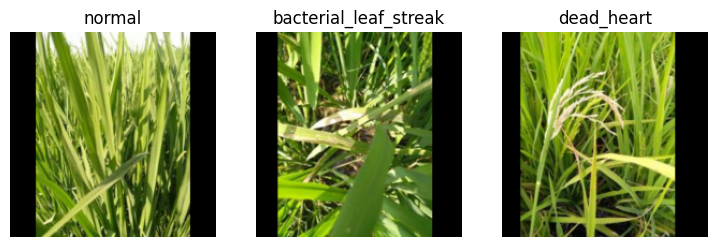

In [11]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [12]:
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.272256,0.880179,0.256607,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.669278,0.407438,0.134551,00:12
1,0.511234,0.380090,0.114849,00:12
2,0.343354,0.242180,0.061509,00:12
3,0.200374,0.191404,0.056223,00:12
4,0.144492,0.162097,0.040365,00:12


That's looking like a pretty good improvement.

## Test time augmentation

To make the predictions even better, we can try [test time augmentation](https://nbviewer.org/github/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb#Test-Time-Augmentation) (TTA), which [our book](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527) defines as:

> *During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.*

Before trying that out, we'll first see how to check the predictions and error rate of our model without TTA:

In [13]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [14]:
error_rate(preds, targs)

TensorBase(0.0404)

That's the same error rate we saw at the end of training, above, so we know that we're doing that correctly.

Here's what our data augmentation is doing -- if you look carefully, you can see that each image is a bit lighter or darker, sometimes flipped, zoomed, rotated, warped, and/or zoomed:

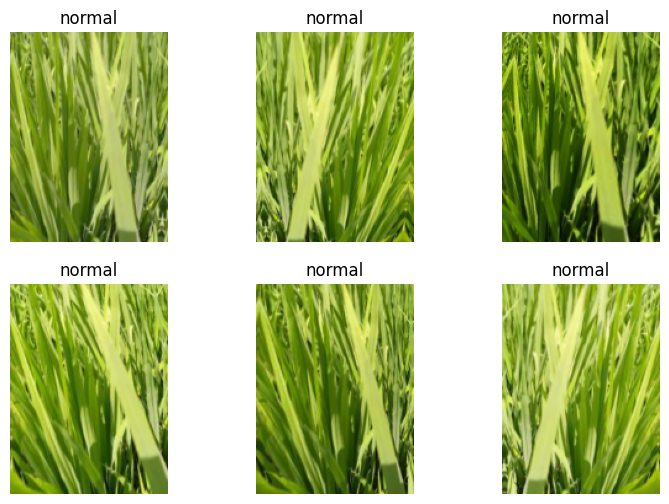

In [15]:
learn.dls.train.show_batch(max_n=6, unique=True)

If we call `tta()` then we'll get the average of predictions made for multiple different augmented versions of each image, along with the unaugmented original:

In [16]:
tta_preds,_ = learn.tta(dl=valid)

Let's check the error rate of this:

In [17]:
error_rate(tta_preds, targs)

TensorBase(0.0404)

That's a huge improvement! We'll definitely want to use this for any submission we make!

## Scaling up

Now that we've got a pretty good model and preprocessing approach, let's scale it up to larger images and more epochs. We'll switch back our path to the original un-resized images, and use 12 epochs using our best settings so far, with larger final augmented images:

In [18]:
trn_path = path/'train_images'

In [19]:
learn = train(arch, epochs=12,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.094196,0.660883,0.201826,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.499121,0.308924,0.100432,00:20
1,0.381885,0.314882,0.098510,00:20
2,0.363334,0.255597,0.083614,00:21
3,0.277406,0.223984,0.064392,00:20
4,0.231930,0.259501,0.071600,00:20
5,0.166683,0.146946,0.041807,00:20
6,0.126190,0.141373,0.037482,00:20
7,0.094145,0.123696,0.028352,00:20
8,0.065586,0.123440,0.026430,00:21
9,0.051803,0.118452,0.027391,00:20


This is around twice as accurate as our previous best model - let's see how it performs with TTA too:

In [20]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0221)

Once again, we get a big boost from TTA. This is one of the most under-appreciated deep learning tricks, in my opinion! (I'm not sure there's any other frameworks that make it quite so easy, so perhaps that's part of the reason why...)

## Submission

We're now ready to get our Kaggle submission sorted. First, we'll grab the test set like we did in the last notebook:

In [21]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = learn.dls.test_dl(tst_files)

Next, do TTA on that test set:

In [22]:
preds,_ = learn.tta(dl=tst_dl)

We need to indices of the largest probability prediction in each row, since that's the index of the predicted disease. `argmax` in PyTorch gives us exactly that:

In [23]:
idxs = preds.argmax(dim=1)

Now we need to look up those indices in the `vocab`. Last time we did that using pandas, although since then I realised there's an even easier way!:

In [24]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [25]:
ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [28]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'convnext small 256x192 12 epochs tta', comp)

100%|██████████| 70.5k/70.5k [00:01<00:00, 65.2kB/s]


This gets a score of 0.9827, which is well within the top 25% of the competition -- that's a big improvement, and we're still using a single small model!

In [27]:
# This is what I use to push my notebook from my home PC to Kaggle

if not iskaggle:
    push_notebook('jhoward', 'small-models-road-to-the-top-part-2',
                  title='Small models: Road to the Top, Part 2',
                  file='09-small-models-road-to-the-top-part-2.ipynb',
                  competition=comp, private=True, gpu=True)

ApiException: (403)
Reason: Forbidden
HTTP response headers: HTTPHeaderDict({'Content-Type': 'application/json', 'Date': 'Thu, 06 Feb 2025 07:41:16 GMT', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Origin': '*', 'Set-Cookie': 'ka_sessionid=0157a595c0c64911202441c7e3cd3e52; max-age=2626560; path=/, GCLB=CNOovMrV6IPNWRAD; path=/; HttpOnly', 'Vary': 'Accept-Encoding', 'X-Kaggle-MillisecondsElapsed': '320', 'X-Kaggle-RequestId': '049abe6bae47a86704c7923b817bd1eb', 'X-Kaggle-ApiVersion': '1.6.17', 'X-Kaggle-HubVersion': '0.3.7', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=63072000; includeSubDomains; preload', 'Content-Security-Policy': "object-src 'none'; script-src 'nonce-oN+E8d5odmgU5e1oAlxeDA==' 'report-sample' 'unsafe-inline' 'unsafe-eval' 'strict-dynamic' https: http:; base-uri 'none'; report-uri https://csp.withgoogle.com/csp/kaggle/20201130; frame-src 'self' https://www.kaggleusercontent.com https://www.youtube.com/embed/ https://polygraph-cool.github.io https://www.google.com/recaptcha/ https://www.docdroid.com https://www.docdroid.net https://kaggle-static.storage.googleapis.com https://kkb-production.jupyter-proxy.kaggle.net https://kkb-production.firebaseapp.com https://kaggle-metastore.firebaseapp.com https://apis.google.com https://content-sheets.googleapis.com/ https://accounts.google.com/ https://storage.googleapis.com https://docs.google.com https://drive.google.com https://calendar.google.com/ https://google.qualtrics.com/ ;", 'X-Content-Type-Options': 'nosniff', 'Referrer-Policy': 'strict-origin-when-cross-origin', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000', 'Transfer-Encoding': 'chunked'})
HTTP response body: {"code":403,"message":"Permission \u0027kernels.setIamPolicy\u0027 was denied"}


## Conclusion

We've made a big step today, despite just using a single model that trains in under 20 minutes even on Kaggle's rather under-powered machines. Next time, we'll try scaling up to some bigger models and doing some ensembling.

If you found this notebook useful, please remember to click the little up-arrow at the top to upvote it, since I like to know when people have found my work useful, and it helps others find it too. And if you have any questions or comments, please pop them below -- I read every comment I receive!